<a href="https://colab.research.google.com/github/MicheleGiambelli/PlotTwisters-Project/blob/main/DEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading of required libraries**

In [1]:
import pandas as pd
import numpy as np
import spacy
import string
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
import networkx as nx
from PIL import Image
import random
from itertools import combinations
from scipy.interpolate import make_interp_spline
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from numpy.random import seed

import torch

!pip install transformers datasets evaluate
!pip install transformers datasets evaluate seqeval

import os
import warnings
warnings.filterwarnings('ignore')

# Librerie di transformers e datasets
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification
from datasets import Dataset, DatasetDict
import evaluate
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  P

In [2]:
df1 = pd.read_csv('sample_data/file5.txt', header=None, delimiter='\t', names=['token', 'ner_tag'])

df2 = pd.read_csv('sample_data/file6.txt', header=None, delimiter='\t', names=['token', 'ner_tag'], skip_blank_lines=False)
df2["token"] = df2["token"].fillna("end")
df2["ner_tag"] = df2["ner_tag"].fillna("end")

#Assegna id di frase a file5
def is_sentence_end(token):
    return token.startswith('http://')

sentence_id = 0
for idx, row in df.iterrows():
    df.loc[idx, 'id'] = sentence_id
    if is_sentence_end(str(row['token'])):
        sentence_id += 1


#Assegna id di frase a file6
for idx, row in df2.iterrows():
  df2.loc[idx, 'id'] = sentence_id
  if row['token'] == 'end' and row["ner_tag"]=="end":
    sentence_id += 1

df2 = df2[df2["ner_tag"] != "end"]



combined_df = pd.concat([df, df2], ignore_index=True)

# Convertire la colonna id da float a int
combined_df['id'] = combined_df['id'].astype(int)

# Verifico corretta unione
print(f"Dimensioni di file5: {df1.shape}")
print(f"Dimensioni di file6: {df2.shape}")
print(f"Dimensioni del dataset combinato: {combined_df.shape}")
print("Etichette uniche nel dataset combinato:")
print(combined_df['ner_tag'].unique())

# Info
print("Informazioni sul DataFrame combinato:")
print(combined_df.info())

combined_df = combined_df.dropna(subset=['token']).reset_index(drop=True) # con questo medodo possiamo rimuovere le righe del dataframe il cui valore è mancante
print("Informazioni sul DataFrame dopo la rimozione dei NaN:")
print(combined_df.info())


# Verifichiamo la presenza di righe vuote (serve più avanti per un problema al codice altrimenti)
invalid_tokens = combined_df[~combined_df['token'].apply(lambda x: isinstance(x, str))]
print("Righe con valori non stringa nella colonna 'token':")
print(invalid_tokens)

# Eliminare le righe con valori non stringa nella colonna 'token'
combined_df = combined_df[combined_df['token'].apply(lambda x: isinstance(x, str))].reset_index(drop=True)


FileNotFoundError: [Errno 2] No such file or directory: 'sample_data/file5.txt'

# **Loading data**


In the following are read text rows containing tokens and NER tags, assigning a unique ID to each sentence. We remove empty or invalid rows, concatenating the data into a single clean DataFrame and convert IDs to integers, preparing the dataset for later processing.

In [5]:
def file_to_dataframe(file_path):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()  # Leggi tutte le righe del file
        for i, line in enumerate(lines):
            line = line.strip()  # Rimuove spazi e newline extra
            if not line:  # Linea vuota, segna come fine frase
                data.append(("end", "end"))
                continue

            # Controlla se la riga contiene '\t' per separare token e tag
            if '\t' in line:
                parts = line.split('\t')
                if len(parts) == 2:  # La riga è valida con 2 parti
                    token, ner_tag = parts
                    data.append((token, ner_tag))
                else:  # Riga malformata
                    print(f"Riga malformata alla linea {i + 1}: {line}")
            else:  # Riga senza '\t'
                print(f"Riga senza tabulazione alla linea {i + 1}: {line}")
                # data.append(("end", "end"))

    return pd.DataFrame(data, columns=['token', 'ner_tag'])

# Converte entrambi i file in DataFrame
df1 = file_to_dataframe('sample_data/file5.txt')
df2 = file_to_dataframe('sample_data/file5.txt')


#Assegna id di frase a file6
sentence_id = 0
for idx, row in df1.iterrows():
  df1.loc[idx, 'id'] = sentence_id
  if row['token'] == 'end' and row["ner_tag"]=="end":
    sentence_id += 1

for idx, row in df2.iterrows():
  df2.loc[idx, 'id'] = sentence_id
  if row['token'] == 'end' and row["ner_tag"]=="end":
    sentence_id += 1


df1 = df1[df1["ner_tag"] != "end"]
df2 = df2[df2["ner_tag"] != "end"]

combined_df = pd.concat([df1, df2], ignore_index=True)

# Convertire la colonna id da float a int
combined_df['id'] = combined_df['id'].astype(int)


combined_df = combined_df.dropna(subset=['token']).reset_index(drop=True) # con questo medodo possiamo rimuovere le righe del dataframe il cui valore è mancante

# Verifichiamo la presenza di righe vuote (serve più avanti per un problema al codice altrimenti)
invalid_tokens = combined_df[~combined_df['token'].apply(lambda x: isinstance(x, str))]

# Eliminare le righe con valori non stringa nella colonna 'token'
combined_df = combined_df[combined_df['token'].apply(lambda x: isinstance(x, str))].reset_index(drop=True)

We used SpaCy with the pre-trained en_core_web_sm template to identify and remove stopwords and punctuation (except @) from the dataset. We implemented a function to clean tokens, remove empty rows, retweets (“rt”) and non-string values.

In [6]:
# Modello di lingua inglese di Spacy
nlp = spacy.load('en_core_web_sm')  # en_core_web_sm è un modello pre addestrato di spacy (small model).
stopwords = nlp.Defaults.stop_words
# Punteggiatura da rimuovere eslusa @
punctuation = set(string.punctuation) - {'@'}

# Funzione per eliminare stopwords e punteggiatura
def remove_stopwords_and_punctuation(df):
    df['token_cleaned'] = df['token'].apply(lambda x: x if x.lower() not in stopwords and x not in punctuation else '') # se è un carattere da rimuovere si crea riga vuota
    df = df[df['token_cleaned'] != '']  # Rimuove le righe con token vuoti
    return df.drop(columns=['token']).rename(columns={'token_cleaned': 'token'}) # si toglie la vecchia colonna "token" e si cambia il nome della nuova colonna "toen_cleaned" con "token"

# Applicare la funzione al dataset combinato
combined_df = remove_stopwords_and_punctuation(combined_df)

# Elimina le righe in cui il token è "rt"
combined_df = combined_df[combined_df['token'] != 'rt']  # "rt" sta per retweet

# Reset dell'indice per un DataFrame pulito (siccome prima abbiamo eliminato righe)
combined_df.reset_index(drop=True, inplace=True)

# Rimuovere eventuali NaN o valori non stringa nella colonna "token"
combined_df = combined_df.dropna(subset=['token']).reset_index(drop=True)
combined_df = combined_df[combined_df['token'].apply(lambda x: isinstance(x, str))].reset_index(drop=True) # manteniamo solo i valori stringa e togliamo il resto

# **Data Exploratory Analysis**

## **Mapping NER tags to simplified categories**



In the following, we decided to group the detailed tags (B-LOC, I-LOC, etc.) under one label (LOC, PER, ORG, O).

The goal is to make the NER tags more interbreable for later analysis and facilitate data visualization without losing important information.

In [7]:
# Mappatura
mapping = {
    'B-LOC': 'LOC',
    'I-LOC': 'LOC',
    'B-PER': 'PER',
    'I-PER': 'PER',
    'B-ORG': 'ORG',
    'I-ORG': 'ORG',
    'O': 'O'
}

# Creazione della nuova colonna 'Label' nel training set
combined_df['Label'] = combined_df['ner_tag'].map(mapping)

## **NER label frequency**



We computed the frequency of NER labels (O, PER, ORG, LOC) in our dataset and generated a bar graph to visualize the distribution. This step allowed us to analyze how the labels are distributed, highlighting any imbalances in the data.

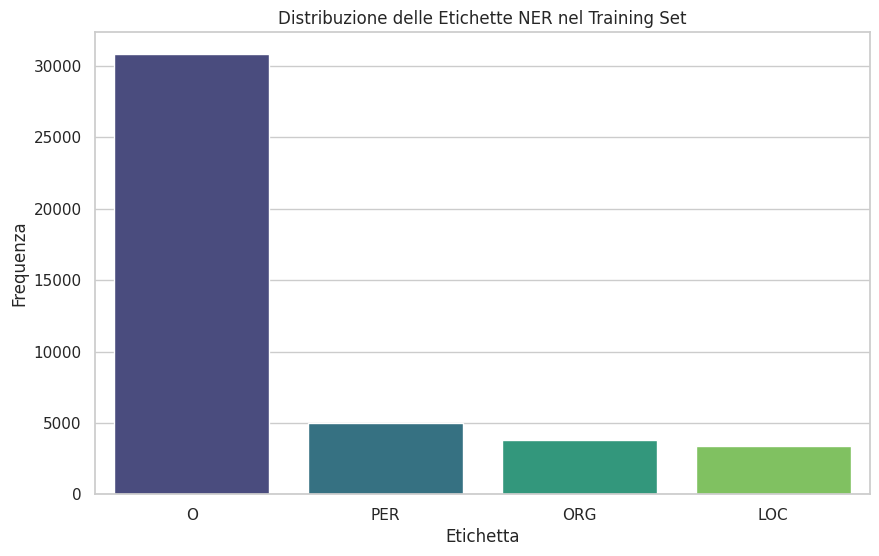

In [8]:
# Contiamo la frequenza di ciascuna etichetta nel training set
label_counts = combined_df['Label'].value_counts()

# Impostiamo lo stile di Seaborn
sns.set(style="whitegrid") # aggiungiamo riga grigia di sfondo

# Creiamo un grafico a barre
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis") # viridis sarebbe una palet di colori chiari


plt.title('Distribuzione delle Etichette NER nel Training Set')
plt.xlabel('Etichetta')
plt.ylabel('Frequenza')

plt.show()

The graph represents the frequency of NER labels in our dataset. We note that the O label (indicating non-entity tokens) is clearly predominant compared to the others (PER, ORG, LOC). This imbalance in the data underscores the importance of a model capable of correctly distinguishing relevant entities, despite the predominance of nonentity tokens.



---

## **Most frequent token entities by category**

We analyzed the most frequent entities for each NER tag category (LOC, PER, ORG, O) in the dataset. Using the get_top_entities_by_label function, we filtered and calculated the most common entities for each category. Finally, we created four bar graphs, one for each category, to display the entities with the highest frequencies.

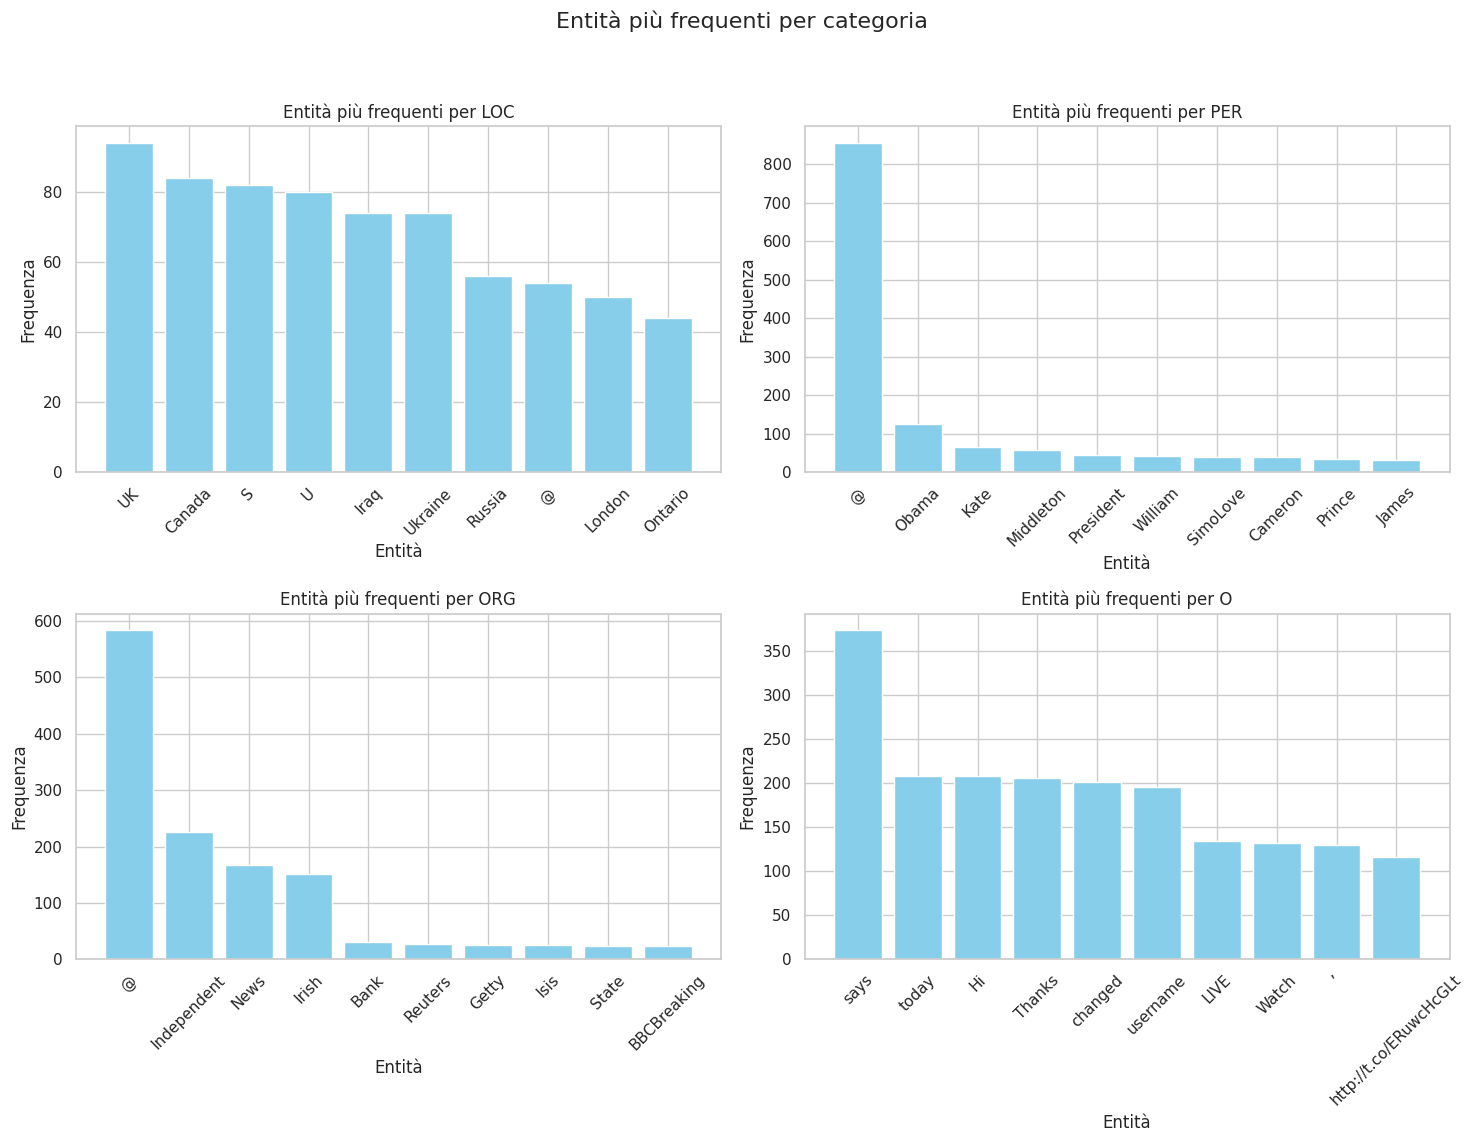

In [9]:
# Entità più frequenti per ogni categoria
def get_top_entities_by_label(data, label, top_n=10):
    # Filtrare i dati per la categoria specificata
    filtered_data = data[data['Label'] == label]
    # Contare i token all'interno della categoria
    entity_counts = Counter(filtered_data['token'])

    return entity_counts.most_common(top_n)


top_loc_entities = get_top_entities_by_label(combined_df, 'LOC')
top_per_entities = get_top_entities_by_label(combined_df, 'PER')
top_org_entities = get_top_entities_by_label(combined_df, 'ORG')
top_o_entities = get_top_entities_by_label(combined_df, 'O')


def plot_top_entities(ax, top_entities, label):
    entities, counts = zip(*top_entities)  # Separiamo entità e frequenze
    ax.bar(entities, counts, color='skyblue')
    ax.set_title(f"Entità più frequenti per {label}")
    ax.set_xlabel("Entità")
    ax.set_ylabel("Frequenza")
    ax.tick_params(axis='x', rotation=45)

# Creazione di un'unica figura con 4 grafici in 2x2
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Entità più frequenti per categoria', fontsize=16)

# Grafico per ciascuna categoria
plot_top_entities(axs[0, 0], top_loc_entities, 'LOC')
plot_top_entities(axs[0, 1], top_per_entities, 'PER')
plot_top_entities(axs[1, 0], top_org_entities, 'ORG')
plot_top_entities(axs[1, 1], top_o_entities, 'O')

# Adattare spazi per evitare sovrapposizioni
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The graphs show the 10 most frequent entities in each category:

- LOC (places): Highlights geographic entities such as countries and cities, with UK and Canada being the most common.
- PER (people): Highlights proper names, with Obama as the dominant entity.
- ORG (organizations): Shows organizations such as Independent and News among the most common.
- O (other): Includes generic or unclassified tokens, with common terms such as says and today prevalent.

This analysis allowed us to identify the most representative entities in our dataset, which was useful for assessing the distribution of categories and better understanding the context of the labels.

---

## **Sentence length distribution**

We calculated the length of each sentence in the dataset by summing the number of tokens for each sentence ID. Next, we visualized the distribution of lengths with a histogram and added a smooth interpolated curve to highlight the data trend, using a cubic spline to improve readability.

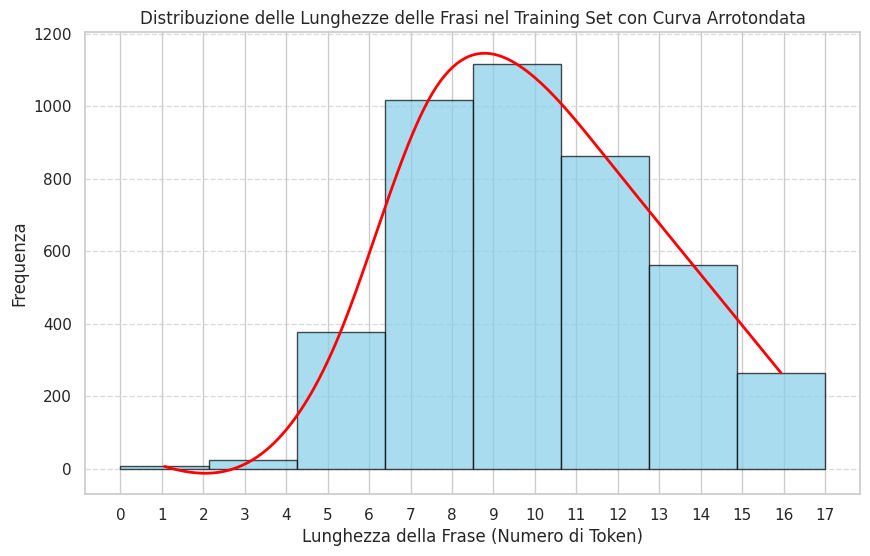

In [10]:
# Calcola la lunghezza di ciascuna frase contando i token per ogni Sentence_Num
sentence_lengths = combined_df.groupby('id').size()

# Visualizza la distribuzione delle lunghezze delle frasi con un istogramma
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=8, range=(0, 17), color='skyblue', edgecolor='black', alpha=0.7)

# Calcola i conteggi per ciascun bin e i centri dei bin
bin_counts, bin_edges = np.histogram(sentence_lengths, bins=8, range=(0, 17))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # Centri dei bin

# Interpolazione spline per rendere la curva tondeggiante
xnew = np.linspace(bin_centers.min(), bin_centers.max(), 300)  # Genera più punti per una curva liscia
spl = make_interp_spline(bin_centers, bin_counts, k=3)  # k=3 per una spline cubica
y_smooth = spl(xnew)

# Aggiungi la curva interpolata al grafico
plt.plot(xnew, y_smooth, color='red', linewidth=2)

# Aggiungi titoli e etichette agli assi
plt.title("Distribuzione delle Lunghezze delle Frasi nel Training Set con Curva Arrotondata")
plt.xlabel("Lunghezza della Frase (Numero di Token)")
plt.ylabel("Frequenza")

# Etichette per l'asse X e griglia
plt.xticks(range(0, 18))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The graph shows the distribution of sentence lengths (in terms of number of tokens) in the dataset. Most of the sentences are between 8 and 12 tokens in length, peaking around 10. The interpolated red curve highlights the overall trend, facilitating visual interpretation. This type of analysis is useful for defining parameters such as maximum length during tokenization.


---


## **Token length distribution according to NER Tag**

We analyzed the token lengths (in number of characters) for each NER label (LOC, PER, ORG, O). After calculating the cumulative percentage distribution of lengths for each category, we created an area graph to visually represent the cumulative composition of token lengths.

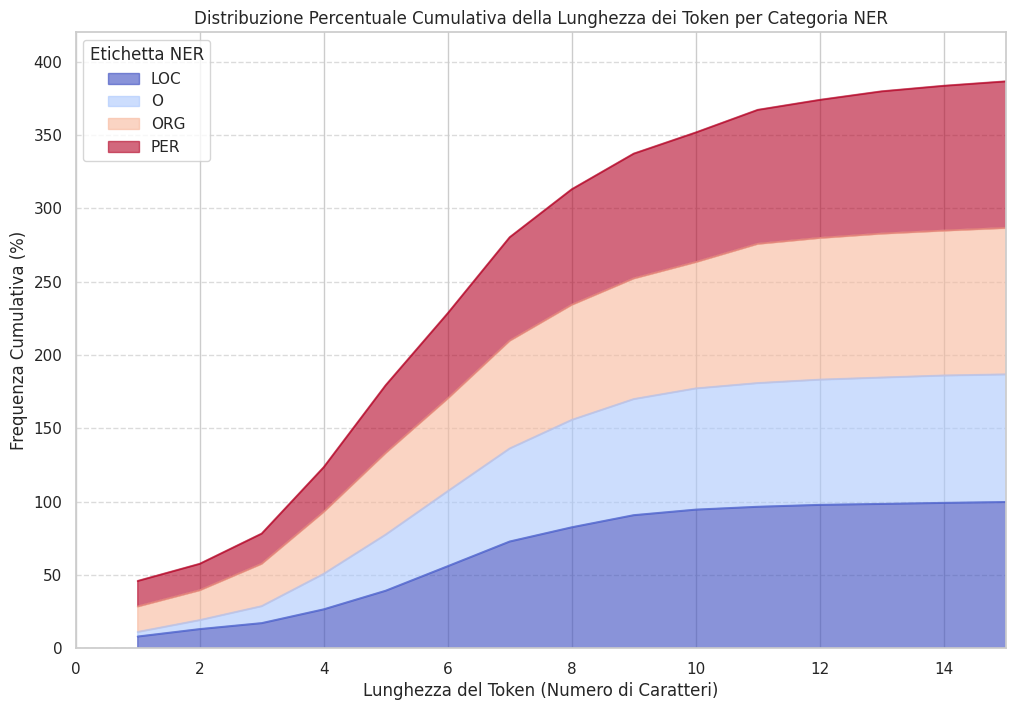

In [11]:
# Calcola la lunghezza di ciascun token in numero di caratteri
combined_df['token_length'] = combined_df['token'].apply(len)

# Calcola la distribuzione delle lunghezze dei token per ciascuna etichetta NER
token_length_distribution = combined_df.groupby(['token_length', 'Label']).size().unstack(fill_value=0)

# Calcola la distribuzione cumulativa per ciascuna etichetta NER in percentuale
token_length_distribution = token_length_distribution.cumsum()
token_length_distribution = (token_length_distribution / token_length_distribution.max()) * 100

# Creazione del grafico ad aree per la distribuzione delle lunghezze dei token
plt.figure(figsize=(12, 8))
token_length_distribution.plot(kind='area', stacked=True, alpha=0.6, colormap="coolwarm", ax=plt.gca())


plt.title("Distribuzione Percentuale Cumulativa della Lunghezza dei Token per Categoria NER")
plt.xlabel("Lunghezza del Token (Numero di Caratteri)")
plt.ylabel("Frequenza Cumulativa (%)")
plt.legend(title="Etichetta NER")
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.xlim(0, 15)  # Limitato a 15 caratteri, considerando la maggior parte dei token


plt.show()

We created a cumulative area plot to represent the cumulative percentage distribution of token length (in characters) for each NER category (LOC, PER, ORG, O).

- X-axis: The length of tokens, measured in number of characters.
- Y-axis: The cumulative frequency in percent, indicating the percentage of tokens included up to a certain length.


Remarks:
- Tokens in the PER category occur more in longer lengths, indicating that people's names tend to have more characters.
- The O category dominates among the shorter tokens, reflecting the presence of common words or short symbols not labeled as entities.
- The LOC and ORG categories grow gradually, but remain less frequent than the others.

This graph allowed us to analyze the cumulative composition of token lengths, helping us to better understand how lengths vary among NER categories.


---


## **Most common pairs of Co-occurrences**

We calculated co-occurrences between word pairs within a context window of ±2 tokens per sentence. The graph shows the 10 most frequent word pairs in the dataset, ordered by frequency.

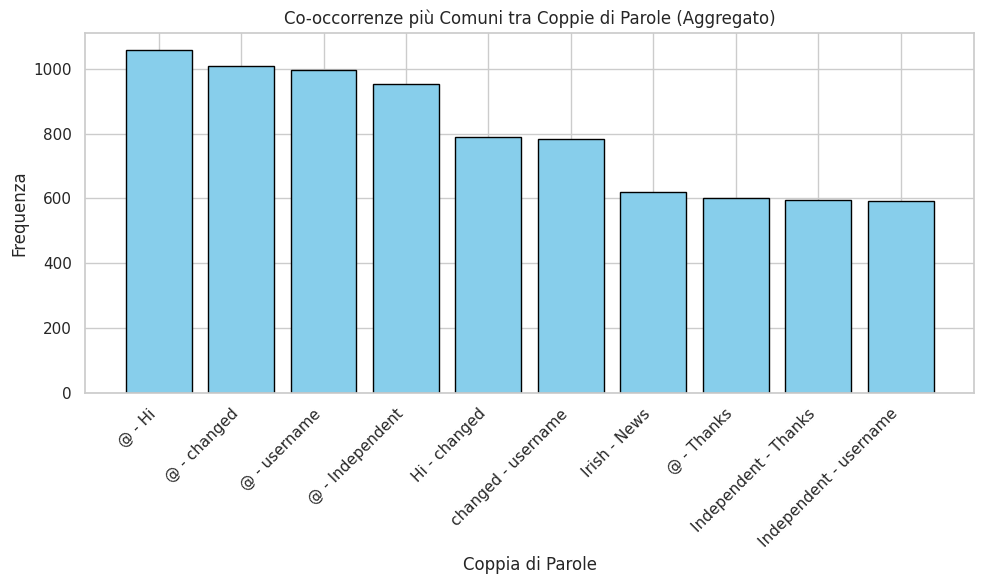

In [12]:
window_size = 2  # Numero di parole prima e dopo

# Funzione per calcolare e aggregare le co-occorrenze tra le parole
def get_aggregated_co_occurrences(data, window_size=2):
    co_occurrences = Counter()

    # Raggruppiamo i dati per 'Sentence_Num' per lavorare frase per frase
    for sentence_num, group in data.groupby('id'):
        tokens = group['token'].tolist()

        # Calcola le co-occorrenze all'interno della finestra di contesto
        for i in range(len(tokens)):
            context_window = tokens[max(0, i - window_size): min(len(tokens), i + window_size + 1)]
            for pair in combinations(context_window, 2):
                if pair[0] != pair[1]:  # Evita co-occorrenze della stessa parola con sé stessa
                    normalized_pair = tuple(sorted(pair))  # Ordina la coppia in ordine alfabetico
                    co_occurrences[normalized_pair] += 1   # Somma le frequenze delle coppie duplicate

    return co_occurrences

# Calcola e aggrega le co-occorrenze più comuni
aggregated_co_occurrences = get_aggregated_co_occurrences(combined_df, window_size=2)

# Ottieni le 10 co-occorrenze più comuni dopo l'aggregazione
top_aggregated_co_occurrences = aggregated_co_occurrences.most_common(10)
pairs, counts = zip(*top_aggregated_co_occurrences)

# Converti le coppie in stringhe per una visualizzazione più semplice
pair_labels = [f"{pair[0]} - {pair[1]}" for pair in pairs]

# Creazione del grafico a barre
plt.figure(figsize=(10, 6))
plt.bar(pair_labels, counts, color='skyblue', edgecolor='black')
plt.title("Co-occorrenze più Comuni tra Coppie di Parole (Aggregato)")
plt.xlabel("Coppia di Parole")
plt.ylabel("Frequenza")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Aggiusta automaticamente il layout per evitare sovrapposizioni
plt.show()



The most frequent co-occurrences include recurring terms such as @ - Hi and @ - changed, probably related to the structure of the data (such as greetings or user tags).

This analysis helps us identify frequent relationships between words, potentially useful for understanding context and optimizing the language model.


---


## **WordCloud**


We created a custom Word Cloud using a mask uploaded by our group, with vibrant colors and an eye-catching design. This visualization highlights the most frequent tokens in the dataset in a unique visual format.

Saving plottwisters_mask.png.png to plottwisters_mask.png.png


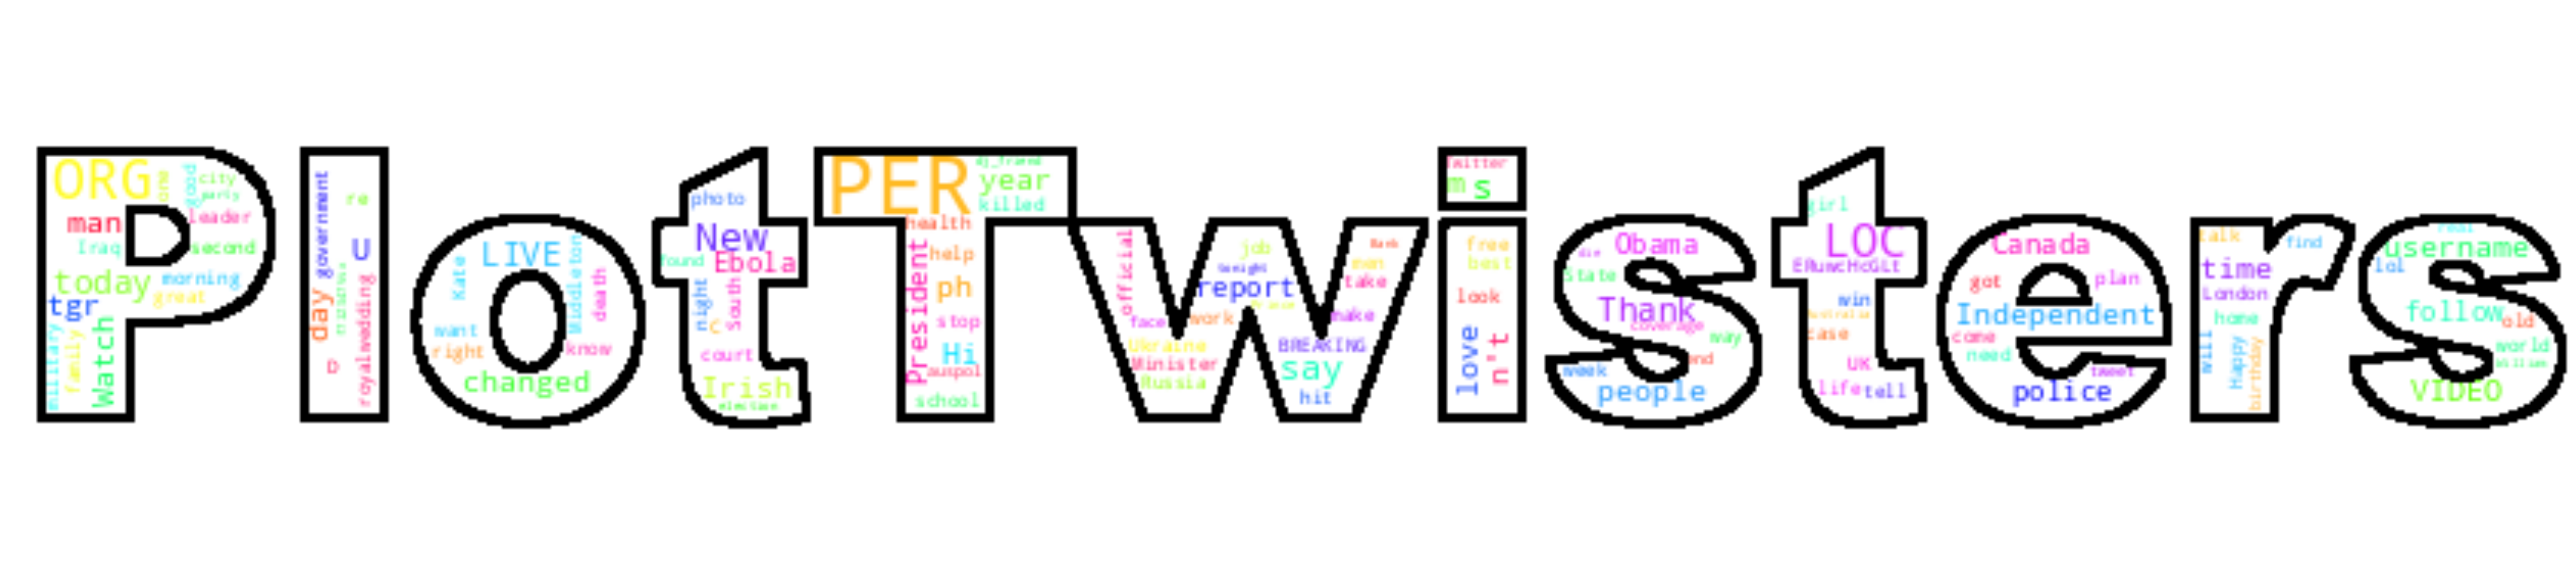

In [ ]:
from google.colab import files

# Carica l'immagine della maschera dal computer
uploaded = files.upload()  # Questo aprirà una finestra per il caricamento del file
mask_image_path = next(iter(uploaded.keys()))  # Ottieni il nome del file caricato
mask_image = np.array(Image.open(mask_image_path))

# Prepara il testo unendo tutti i token del dataset di training
text = " ".join(combined_df['token'].astype(str))

# Definisci le stopwords
stopwords = set(STOPWORDS)
stopwords.update(['DOCSTART', 'http', 'https', 't', 'co', 'RT','O', 'B' ])  # Aggiungi ulteriori parole se necessario

# Funzione di colore personalizzata per colori vivaci e saturi
def vibrant_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    h = int(360.0 * random.random())  # Colori casuali
    s = 100  # Saturazione massima
    l = 50 + random.random() * 10  # Luminosità media
    return f"hsl({h}, {s}%, {l}%)"

# Crea e genera la Word Cloud con contorni più marcati e colori più vivaci
wordcloud = WordCloud(
    width=mask_image.shape[1] * 2,  # Aumenta la risoluzione
    height=mask_image.shape[0] * 2,  # Aumenta la risoluzione
    background_color='white',
    mask=mask_image,
    stopwords=stopwords,
    max_words=300,  # Riduci il numero massimo di parole
    max_font_size=300,  # Aumenta la dimensione massima del font per ingrandire le parole
    contour_width=4,  # Contorno più marcato
    contour_color='black',
    random_state=42,
    collocations=False  # Evita duplicati di parole
).generate(text)

# Visualizza la Word Cloud con la funzione di colore personalizzata
plt.figure(figsize=(40, 20))  # Aumenta ulteriormente le dimensioni della figura per migliorare la risoluzione
plt.imshow(wordcloud.recolor(color_func=vibrant_color_func), interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Salva l'immagine in un file (opzionale)
wordcloud.to_file('plottwisters_wordcloud_vibrant.png')


---

## **Matrix of co-occurrences between NER Labels**




We generated a co-occurrence matrix of NER labels, represented as a heatmap. This graph shows how many times two different NER labels appear together in the same sentence of the dataset.

Etichette trovate nella colonna 'Label': ['O' 'ORG' 'PER' 'LOC']


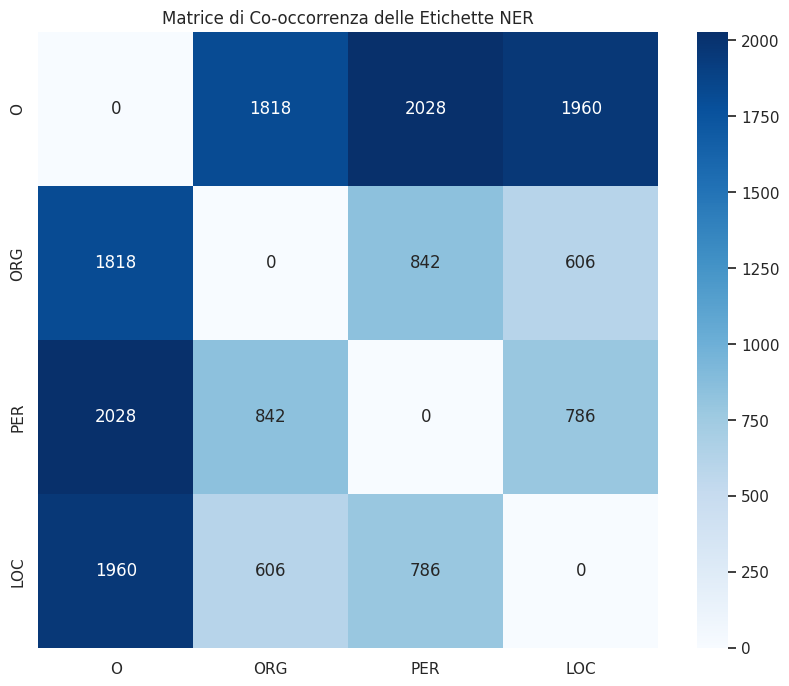

In [13]:
# Estrai i valori unici dalla colonna 'Label' per garantire che tutte le etichette siano incluse
unique_labels = combined_df['Label'].unique()
print("Etichette trovate nella colonna 'Label':", unique_labels)

# Raggruppiamo per 'Sentence_Num' e raccogliamo tutte le etichette presenti in ciascuna frase
ner_per_sentence = combined_df.groupby('id')['Label'].apply(lambda x: list(set(x))).reset_index()

# Inizializza una matrice di co-occorrenza con zero per ciascuna coppia di etichette
co_occurrence_matrix = pd.DataFrame(0, index=unique_labels, columns=unique_labels)

# Compila la matrice di co-occorrenza
for labels in ner_per_sentence['Label']:
    for label1 in labels:
        for label2 in labels:
            if label1 != label2:  # Evita di contare una coppia della stessa etichetta
                co_occurrence_matrix.loc[label1, label2] += 1

# Visualizza la matrice di co-occorrenza
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=True, cmap='Blues', fmt="d")
plt.title("Matrice di Co-occorrenza delle Etichette NER")
plt.show()

- Major co-occurrences:
   1. O co-occurs frequently with ORG (1818 times), PER (2028 times) and LOC (1960 times).
   2. ORG and PER appear together in 842 sentences, while ORG co-occurs with LOC 606 times.
   3. PER and LOC show co-occurrence in 786 sentences.
- Absence of self-co-occurrence: The values on the diagonal are all 0, as we do not count the co-occurrence of a label with itself.

---


8. **Distribuzione delle Parti del Discorso (POS Tags)**

Questo codice ha lo scopo di analizzare la distribuzione dei POS (Part-of-Speech) tags presenti nei token del dataset di training. Utilizzando il modello linguistico di spaCy, il codice assegna a ciascun token un'etichetta POS, che indica la sua funzione grammaticale (come sostantivo, verbo, aggettivo, ecc.).

Visualizzare questa distribuzione mi permette di capire quali tipi di parole sono più comuni nel testo e di ottenere un quadro generale della struttura linguistica del dataset.

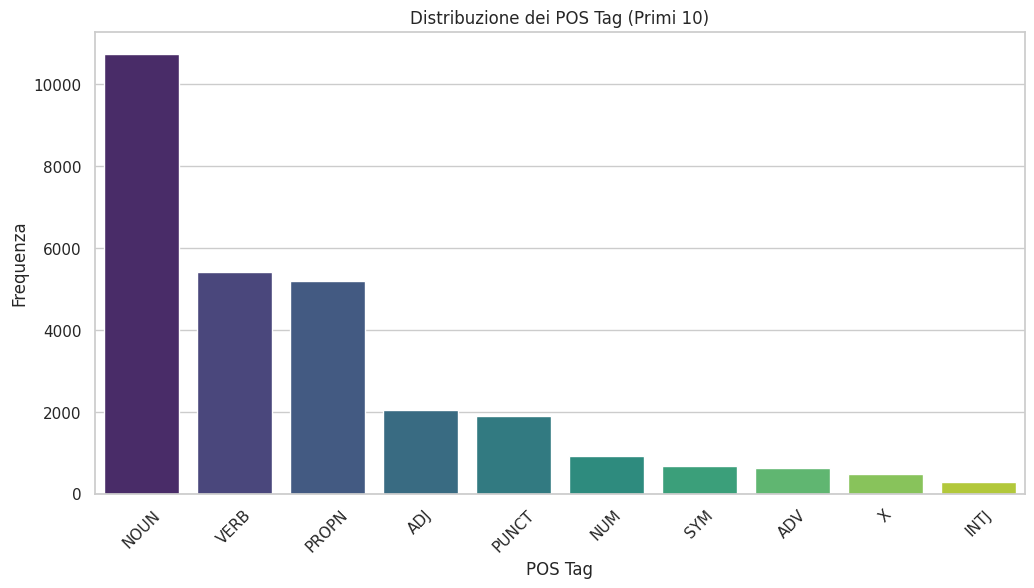

In [ ]:
# Carica il modello di spaCy e disattiva componenti inutili per velocizzare il processo
nlp = spacy.load('en_core_web_sm', disable=["ner", "parser"])

# Funzione per ottenere i POS tag per ogni token in modalità batch
def get_pos_tags_in_batch(tokens):
    # Concatena tutti i token in un unico documento spaCy
    docs = list(nlp.pipe(tokens, batch_size=1000))  # Usa la pipe per processare in batch.
                                                    # nlp.pipe permette di processare i token in batch.
                                                    # Specificando un batch_size (in questo esempio, 1000), spaCy elabora i dati in blocchi, migliorando le prestazioni.
    # Estrai solo il POS tag del primo token di ogni doc
    pos_tags = [doc[0].pos_ if len(doc) > 0 else 'X' for doc in docs]
    return pos_tags

# Applica la funzione a tutti i token del dataset in modalità batch
combined_df['pos_tag'] = get_pos_tags_in_batch(combined_df['token'].tolist()) # get_pos_tags_in_batch: Questa funzione elabora i token in batch e restituisce solo il POS tag di ciascun token, riducendo il tempo di calcolo.

# Calcola la distribuzione dei POS tag
pos_counts = combined_df['pos_tag'].value_counts()

# Limita la distribuzione ai primi 10 POS tag
top_10_pos_counts = pos_counts.head(10)

# Visualizza la distribuzione dei primi 10 POS tag con un grafico a barre
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_pos_counts.index, y=top_10_pos_counts.values, palette="viridis")
plt.title("Distribuzione dei POS Tag (Primi 10)")
plt.xlabel("POS Tag")
plt.ylabel("Frequenza")
plt.xticks(rotation=45)
plt.show()



---











9. **Analisi di Sentiment**

Nel segeunte modello di sentiment analisi trasformer utilizza *DistilBERT Fine-Tuned su SST-2* . Questo modello è stato addestrato sul Stanford Sentiment Treebank (SST-2), un dataset composto principalmente da recensioni cinematografiche. Di conseguenza, il modello è ottimizzato per riconoscere sentimenti positivi e negativi in quel contesto specifico.

Classi di Sentiment: Questo modello restituisce due classi, POSITIVE e NEGATIVE, quindi è progettato per sentiment binario.

Architettura: DistilBERT è una versione ottimizzata e più leggera del modello BERT, sviluppata per essere più veloce e meno dispendiosa in termini di memoria, mantenendo al contempo un'accuratezza elevata.



No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

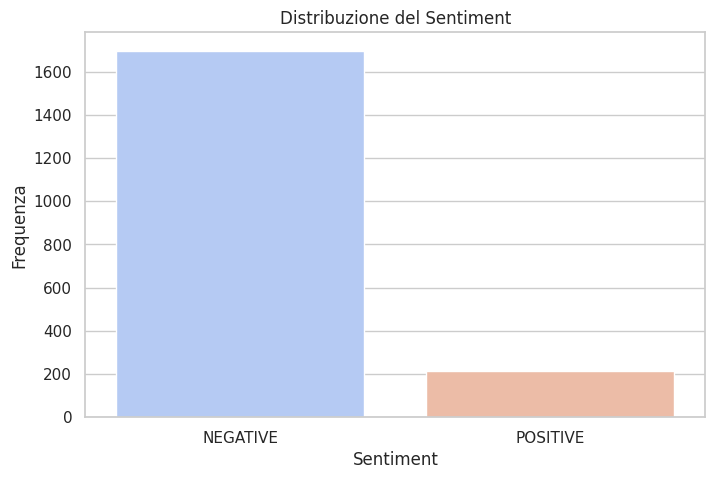

In [ ]:
# Inizializza il pipeline di sentiment analysis
sentiment_analyzer = pipeline("sentiment-analysis")

# Funzione per troncare le frasi a 512 caratteri
def truncate_text(text, max_length=512):
    return text[:max_length]

# Raggruppa i token per frase e crea un testo completo per ciascuna frase
sentences = combined_df.groupby('id')['token'].apply(lambda x: ' '.join(x)).tolist()

# Applica la troncatura a tutte le frasi
sentences = [truncate_text(sentence) for sentence in sentences]

# Funzione per eseguire il sentiment analysis in batch
def get_batch_sentiment(sentences, batch_size=100):
    sentiments = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        results = sentiment_analyzer(batch)
        sentiments.extend([res['label'] for res in results])  # Estrai solo la label del sentiment
    return sentiments

# Applica il sentiment analysis in batch su tutte le frasi
sentiments = get_batch_sentiment(sentences)

# Crea un DataFrame con i risultati del sentiment per ciascuna frase
sentiment_df = pd.DataFrame({'id': range(len(sentiments)), 'sentiment': sentiments})

# Conta la distribuzione dei sentiment
sentiment_counts = sentiment_df['sentiment'].value_counts()

# Visualizza la distribuzione dei sentiment con un grafico a barre
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Distribuzione del Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Frequenza")
plt.show()

Questo secondo modello utilizza *Twitter RoBERTa base* che è stato specificatamente addestrato su dati provenienti da Twitter, più adatto quindi al nostro dataset.

Classi di Sentiment: Questo modello restituisce tre classi, POSITIVE, NEUTRAL, e NEGATIVE, il che lo rende più adatto a rappresentare la complessità del linguaggio dei social media.

Architettura: Basato su RoBERTa, un modello robusto e ottimizzato per il natural language processing, che offre un’alta accuratezza.

Limiti:essendo stato addestrato su Twitter, potrebbe riflettere bias presenti nei dati originali. Inoltre Come molti modelli basati su RoBERTa, Twitter RoBERTa base ha un limite di 512 token. Sebbene i tweet siano generalmente brevi, alcuni tweet con molte menzioni o hashtag potrebbero superare questo limite.

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

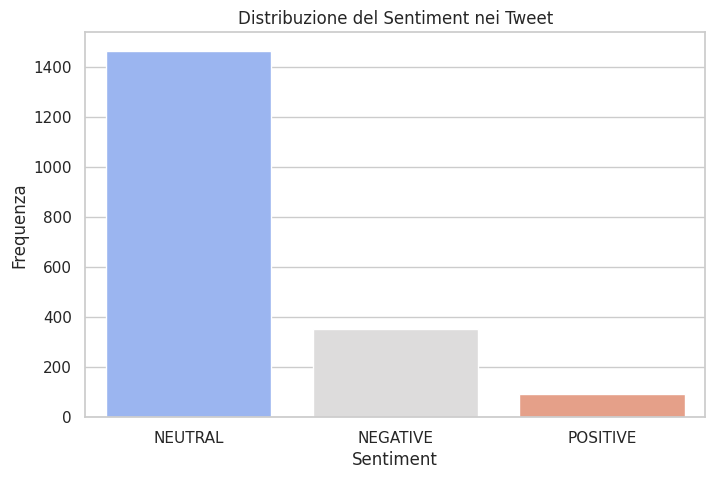

In [ ]:
# Inizializza il pipeline di sentiment analysis con il modello specifico per Twitter
sentiment_analyzer = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Funzione per troncare le frasi a 512 caratteri
def truncate_text(text, max_length=512):
    return text[:max_length]

# Raggruppa i token per frase e crea un testo completo per ciascuna frase
sentences = combined_df.groupby('id')['token'].apply(lambda x: ' '.join(x)).tolist()

# Applica la troncatura a tutte le frasi
sentences = [truncate_text(sentence) for sentence in sentences]

# Funzione per eseguire il sentiment analysis in batch con etichette interpretate
def get_batch_sentiment(sentences, batch_size=50):
    sentiments = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        results = sentiment_analyzer(batch)
        # Mappa le etichette numeriche ai nomi dei sentiment
        sentiments.extend([{'LABEL_0': 'NEGATIVE', 'LABEL_1': 'NEUTRAL', 'LABEL_2': 'POSITIVE'}[res['label']] for res in results])
    return sentiments

# Applica il sentiment analysis in batch su tutte le frasi
sentiments = get_batch_sentiment(sentences)

# Crea un DataFrame con i risultati del sentiment per ciascuna frase
sentiment_df = pd.DataFrame({'id': range(len(sentiments)), 'sentiment': sentiments})

# Conta la distribuzione dei sentiment
sentiment_counts = sentiment_df['sentiment'].value_counts()

# Visualizza la distribuzione dei sentiment con un grafico a barre
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Distribuzione del Sentiment nei Tweet")
plt.xlabel("Sentiment")
plt.ylabel("Frequenza")
plt.show()